In [1]:
#Group project

In [1]:
# import packages
library(tidyverse)
library(readxl)
library(repr)
library(tidymodels)                                    
library("data.table")  
library(GGally)
options(repr.matrix.max.rows = 6)
# Set the seed
set.seed(100)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
# url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"
# file <- download.file(url, 'data/completeData.xls')
# train <- read_excel('data/completeData.xls', sheet='Training_Data')
# train

In [3]:
url <- "https://github.com/YitongZhang01/DSCI100_Group_Project/blob/main/data/Training_data.xls?raw=true"
file <- download.file(url, 'data/training_data.xls')
train <- read_excel('data/training_data.xls') %>% mutate(Class = as_factor(UNS))
# data <- read_xls(path = 'Group_project/DSCI100_Group_Project/data/training_test.xls')
# data <- read_excel('Group_project/DSCI100_Group_Project/data/training.xls')

# train <- read_excel(url) %>% mutate(Class = as_factor(UNS))


In [4]:
train

STG,SCG,STR,LPR,PEG,UNS,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low,very_low
0.08,0.08,0.10,0.24,0.90,High,High
0.06,0.06,0.05,0.25,0.33,Low,Low
⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,High,High
0.50,0.75,0.81,0.61,0.26,Middle,Middle
0.66,0.90,0.76,0.87,0.74,High,High


In [5]:
# explore data
num_obs <- nrow(train)
train_exp <- train %>%
  group_by(Class) %>%
  summarize(
    count = n(),
    percentage = n() / num_obs * 100,
    mean = num_obs/4
  )%>%
arrange(by=desc(percentage))
train_exp

#calculate the average for each column
train_avg<- summarize(train, 
        across(STG:PEG,mean))
train_avg



`summarise()` ungrouping output (override with `.groups` argument)



Class,count,percentage,mean
<fct>,<int>,<dbl>,<dbl>
Middle,88,34.108527,64.5
Low,83,32.170543,64.5
High,63,24.418605,64.5
very_low,24,9.302326,64.5


STG,SCG,STR,LPR,PEG
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3711473,0.3556744,0.4680039,0.4327132,0.4585388


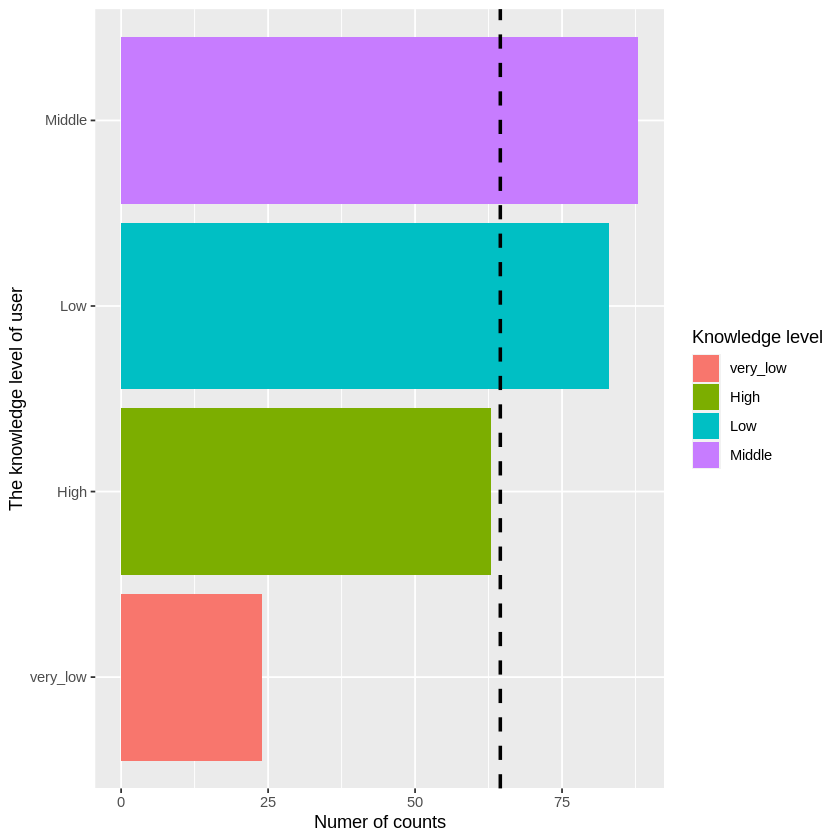

In [6]:
# Visualize different numbers of knowledge level, and indicage the mean of 64.5
UNS_bar <- ggplot(train_exp, aes(x = count, y = Class,fill = Class)) +
  geom_bar(stat = "identity") +
labs(x= "Numer of counts", y= "The knowledge level of user", fill="Knowledge level")+
  geom_vline(xintercept = 64.5, linetype = "dashed", size = 1)

UNS_bar


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



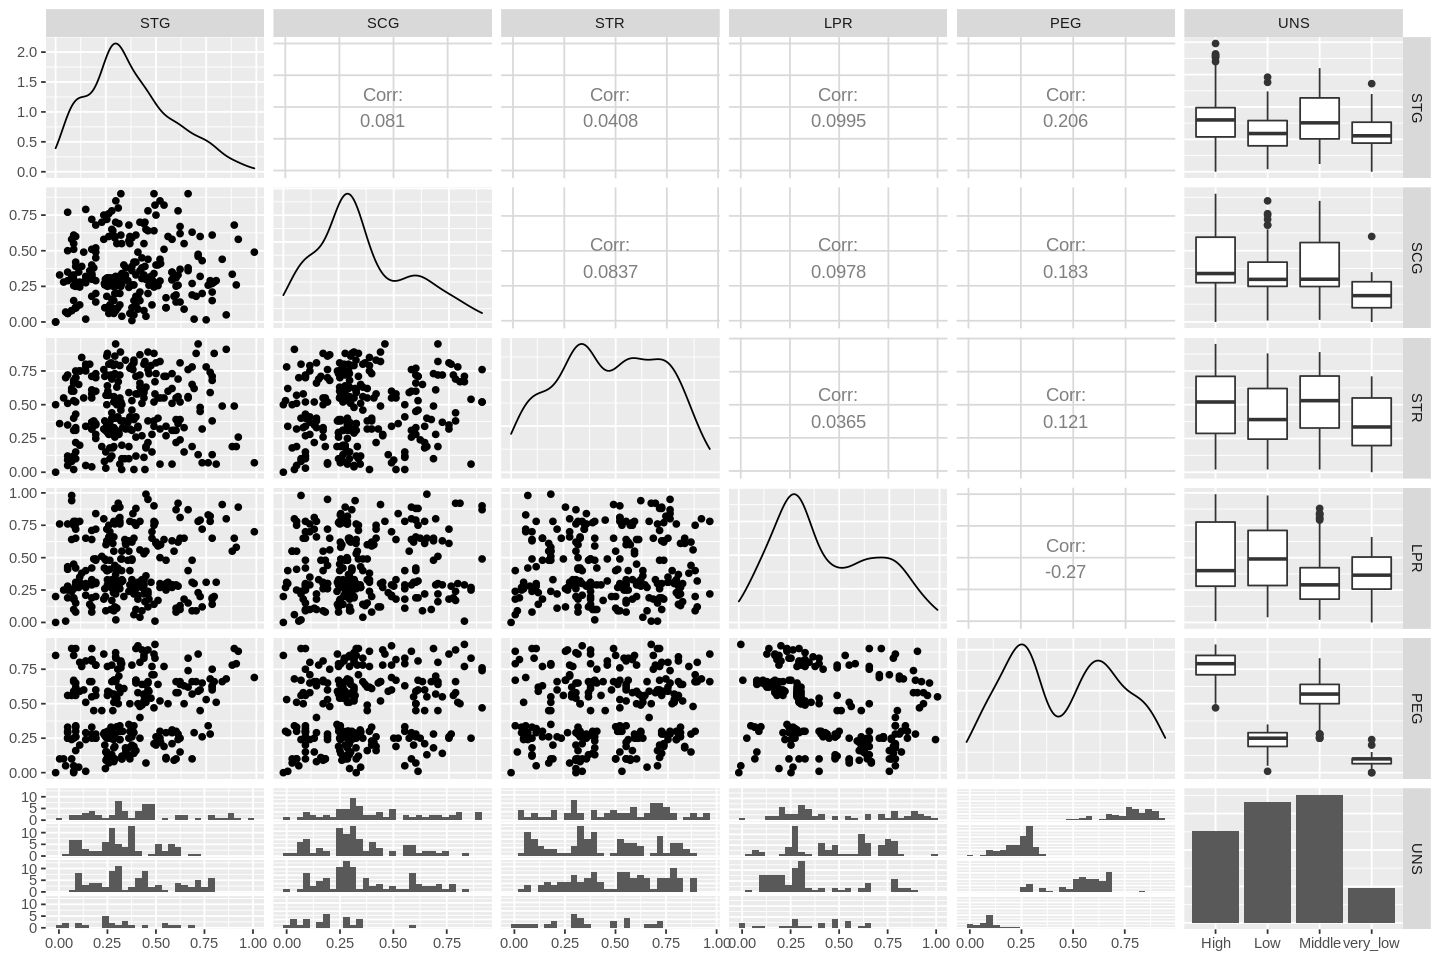

In [7]:
#scatter plot to visualize using ggpairs
options(repr.plot.width = 12, repr.plot.height = 8)
train_eda <- train %>%  
    ggpairs(column =1:6)

train_eda 

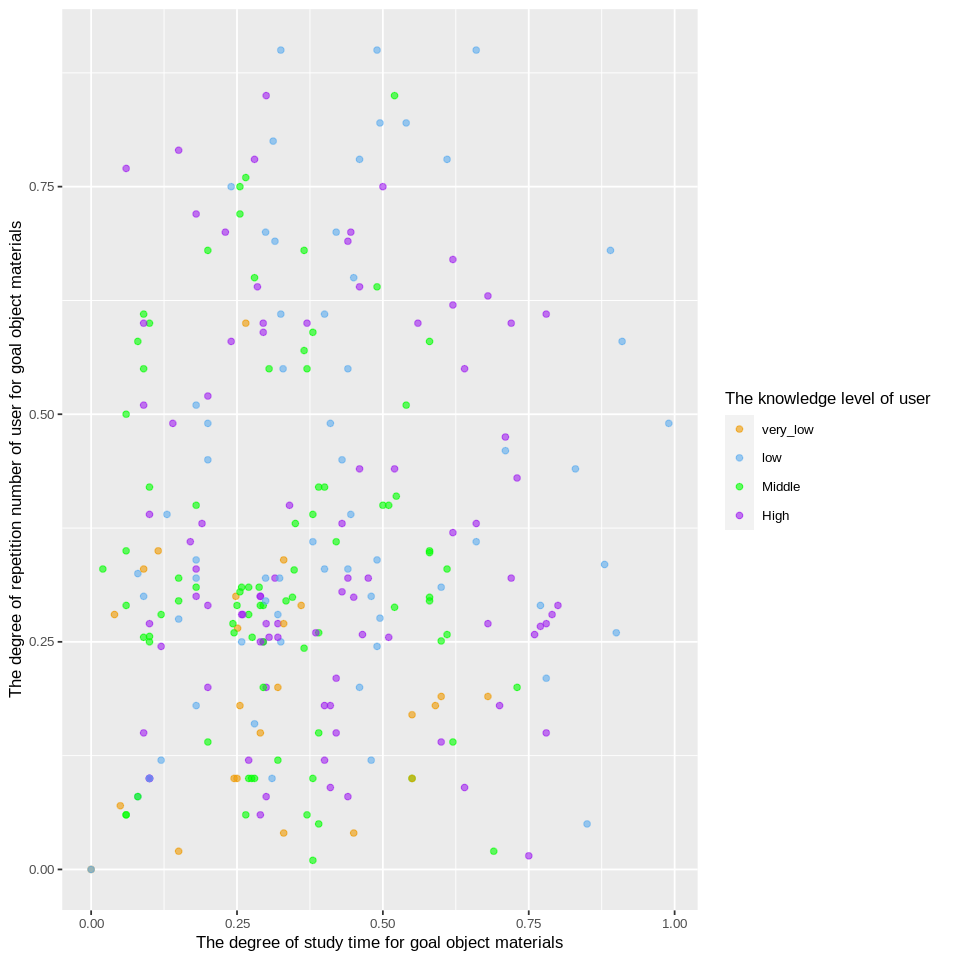

In [8]:
#scatter plot comparisons
options(repr.plot.width = 8, repr.plot.height = 8)
perim_concav <- train %>%
  ggplot(aes(x = STG, y = SCG, color = Class)) +
  geom_point(alpha = 0.6) +
  labs(x = "The degree of study time for goal object materials", 
       y = "The degree of repetition number of user for goal object materials",
       color = "The knowledge level of user") +
  scale_color_manual(labels = c("very_low","low", "Middle","High"), 
                     values = c("orange2", "steelblue2","green","purple")) +
  theme(text = element_text(size = 10))
perim_concav

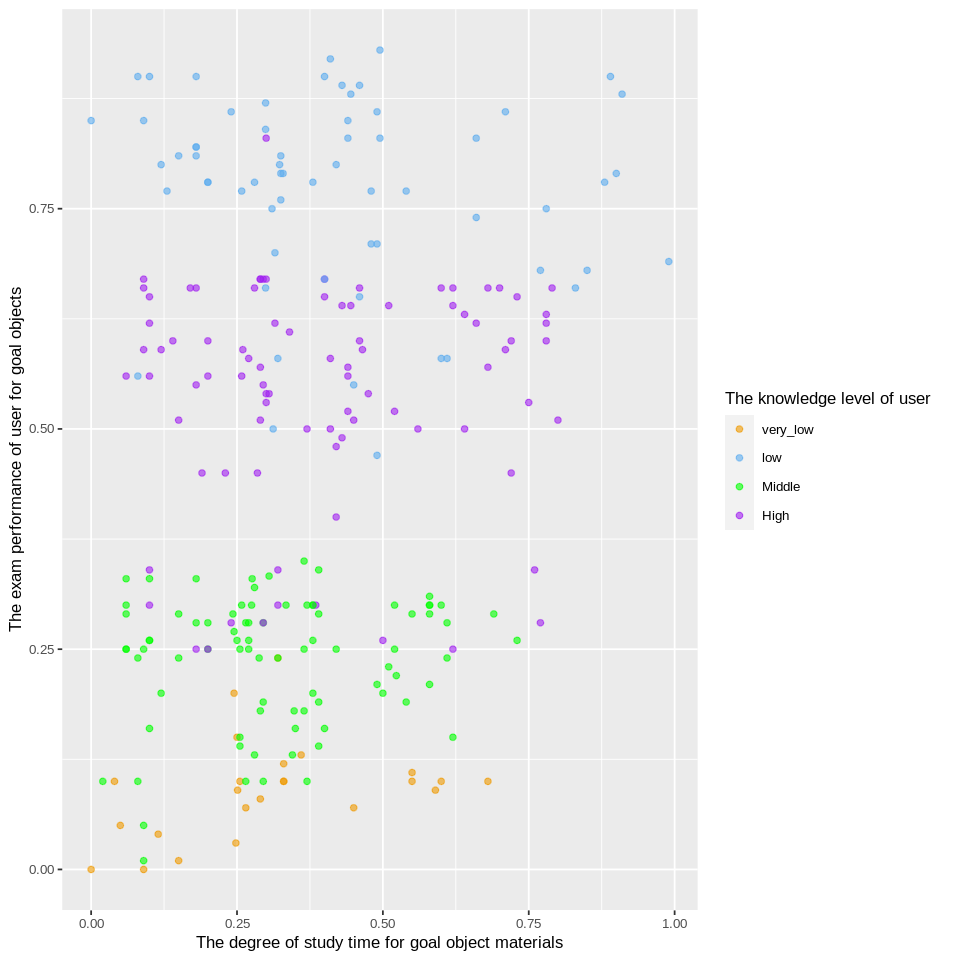

In [9]:
#scatter plot comparisons
options(repr.plot.width = 8, repr.plot.height = 8)
perim_concav_2 <- train %>%
  ggplot(aes(x = STG, y = PEG, color = Class)) +
  geom_point(alpha = 0.6) +
  labs(x = "The degree of study time for goal object materials", 
       y = "The exam performance of user for goal objects",
       color = "The knowledge level of user") +
  scale_color_manual(labels = c("very_low","low", "Middle","High"), 
                     values = c("orange2", "steelblue2","green","purple")) +
  theme(text = element_text(size = 10))
perim_concav_2

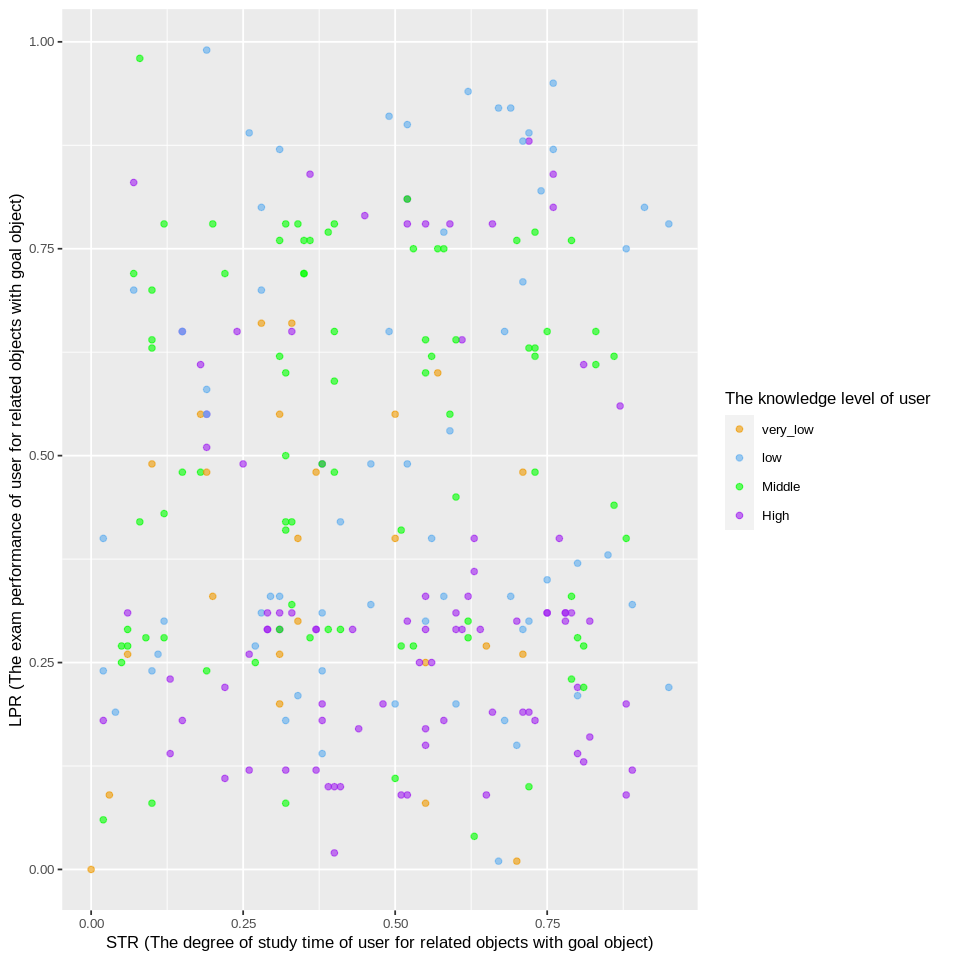

In [10]:
#scatter plot comparisons
options(repr.plot.width = 8, repr.plot.height = 8)
perim_concav_3 <- train %>%
  ggplot(aes( x= STR, y = LPR, color = Class)) +
  geom_point(alpha = 0.6) +
  labs(x = "STR (The degree of study time of user for related objects with goal object)", 
       y = "LPR (The exam performance of user for related objects with goal object)",
       color = "The knowledge level of user") +
  scale_color_manual(labels = c("very_low","low", "Middle","High"), 
                     values = c("orange2", "steelblue2","green","purple")) +
  theme(text = element_text(size = 10))
perim_concav_3

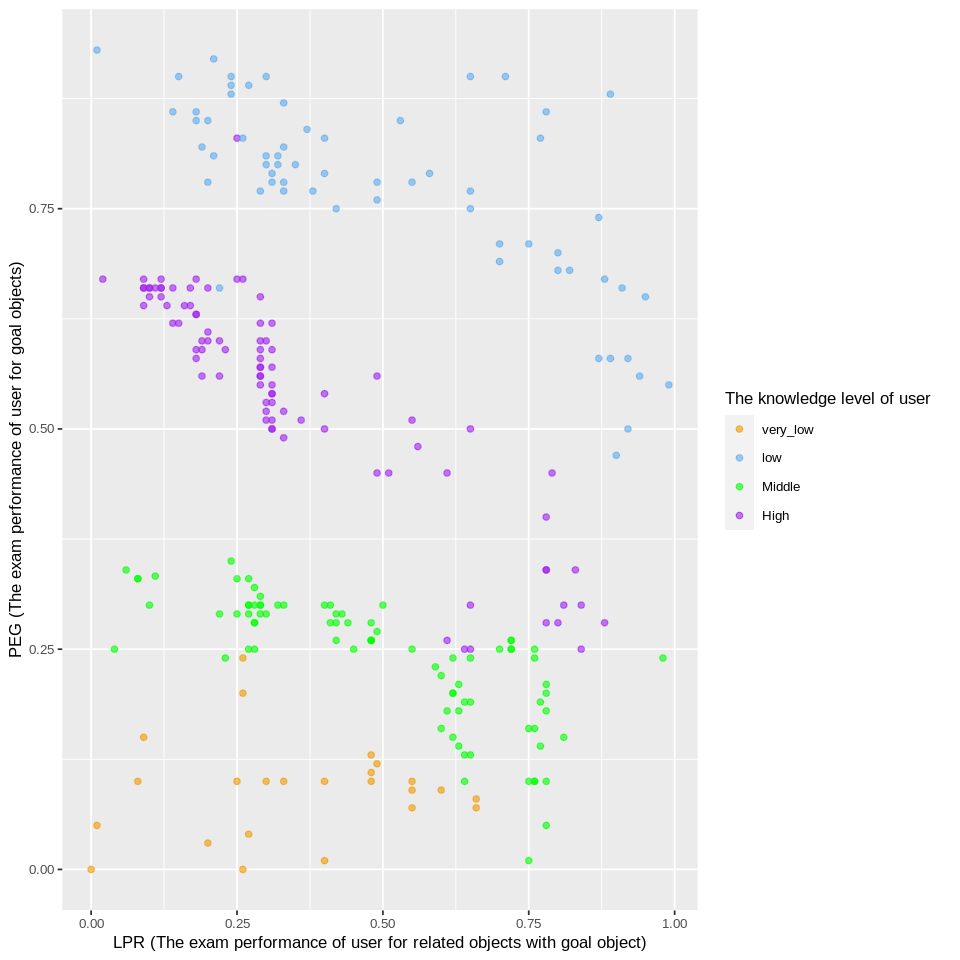

In [11]:
#scatter plot comparisons
options(repr.plot.width = 8, repr.plot.height = 8)
perim_concav_4 <- train %>%
  ggplot(aes(x = LPR, y = PEG, color = Class)) +
  geom_point(alpha = 0.6) +
  labs(x = "LPR (The exam performance of user for related objects with goal object)", 
       y = "PEG (The exam performance of user for goal objects)",
       color = "The knowledge level of user") +
  scale_color_manual(labels = c("very_low","low", "Middle","High"), 
                     values = c("orange2", "steelblue2","green","purple")) +
  theme(text = element_text(size = 10))
perim_concav_4

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.9613674,5,0.005864803,Model01
2,accuracy,multiclass,0.9613674,5,0.005864803,Model02
3,accuracy,multiclass,0.9498986,5,0.007158801,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
8,accuracy,multiclass,0.9536722,5,0.007295183,Model08
9,accuracy,multiclass,0.9496722,5,0.007520912,Model09
10,accuracy,multiclass,0.9496722,5,0.007520912,Model10


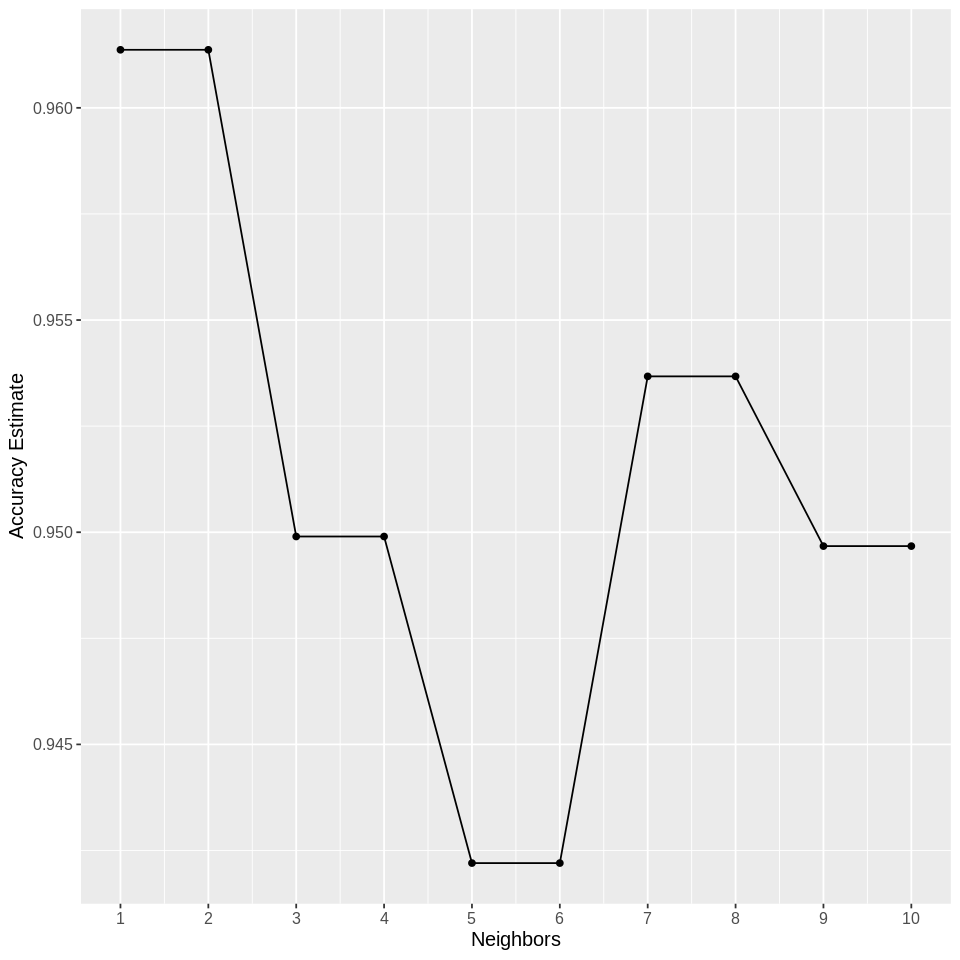

In [12]:
#Create the recipe and standardize it to all variables in a data set have a mean of 0 and a standard deviation of 1. 
data_recipe<- recipe(Class ~ LPR + PEG , data = train) %>%
                       step_scale(all_predictors()) %>%
                       step_center(all_predictors())
##define the model
ks <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

data_vfold <- vfold_cv(train, v = 5, strata = Class)

results <- workflow() %>%
  add_recipe(data_recipe) %>%
  add_model(knn_spec) %>%
  tune_grid(resamples = data_vfold, grid = ks) %>%
  collect_metrics()

accuracies <- results %>%
  filter(.metric == "accuracy")
accuracies 

#visualize the accuracy

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12)) + 
  scale_x_continuous(breaks = 1:10)

accuracy_vs_k


In [13]:
#train the model with correct K value and fit the model
knn_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>%
  set_engine("kknn") %>%
  set_mode("classification")

model_fit<- workflow() %>%
            add_recipe(data_recipe) %>%
            add_model(knn_spec_best) %>%
            fit(data=train)
model_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~5, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.04263566
Best kernel: rectangular
Best k: 5

In [14]:
# url_1 <- "https://github.com/YitongZhang01/DSCI100_Group_Project/blob/main/data/test_data.xlsx?raw=true"
# file_1 <- download.file(url_1, 'data/testing_data.xls')
# test <- read_excel('data/testing_data.xls')
# test
test <- read_excel("data/test_data.xlsx") %>% mutate(Class = as_factor(UNS))
test

STG,SCG,STR,LPR,PEG,UNS,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
0.00,0.10,0.50,0.26,0.05,very_low,very_low
0.05,0.05,0.55,0.60,0.14,Low,Low
0.08,0.18,0.63,0.60,0.85,High,High
⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.56,0.60,0.77,0.13,0.32,Low,Low
0.66,0.68,0.81,0.57,0.57,Middle,Middle
0.68,0.64,0.79,0.97,0.24,Middle,Middle


In [15]:
test_predictions <- predict(model_fit, test) %>%
                    bind_cols(test)
test_predictions

.pred_class,STG,SCG,STR,LPR,PEG,UNS,Class
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
very_low,0.00,0.10,0.50,0.26,0.05,very_low,very_low
Low,0.05,0.05,0.55,0.60,0.14,Low,Low
High,0.08,0.18,0.63,0.60,0.85,High,High
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Low,0.56,0.60,0.77,0.13,0.32,Low,Low
Middle,0.66,0.68,0.81,0.57,0.57,Middle,Middle
Middle,0.68,0.64,0.79,0.97,0.24,Middle,Middle


In [16]:
# get prediction on test
test_predictions %>% 
                    mutate(.pred_class = factor(.pred_class, levels = c("very_low", "Low", "High", "Middle")))%>%
                    metrics(truth = Class, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9724138
kap,multiclass,0.9626192


In [17]:
#using  confusion matrix to check the accruacy of classifier.
model_mat <- test_predictions %>% 
 mutate(.pred_class = factor(.pred_class, levels = c("very_low", "Low", "High", "Middle")))%>% 
                            conf_mat(truth = Class, estimate =.pred_class)  
model_mat

          Truth
Prediction very_low Low High Middle
  very_low       24   0    0      0
  Low             2  45    0      1
  High            0   0   39      0
  Middle          0   1    0     33

Prediction,Truth,Freq
<fct>,<fct>,<int>
very_low,very_low,24
Low,very_low,2
High,very_low,0
⋮,⋮,⋮
Low,Middle,1
High,Middle,0
Middle,Middle,33


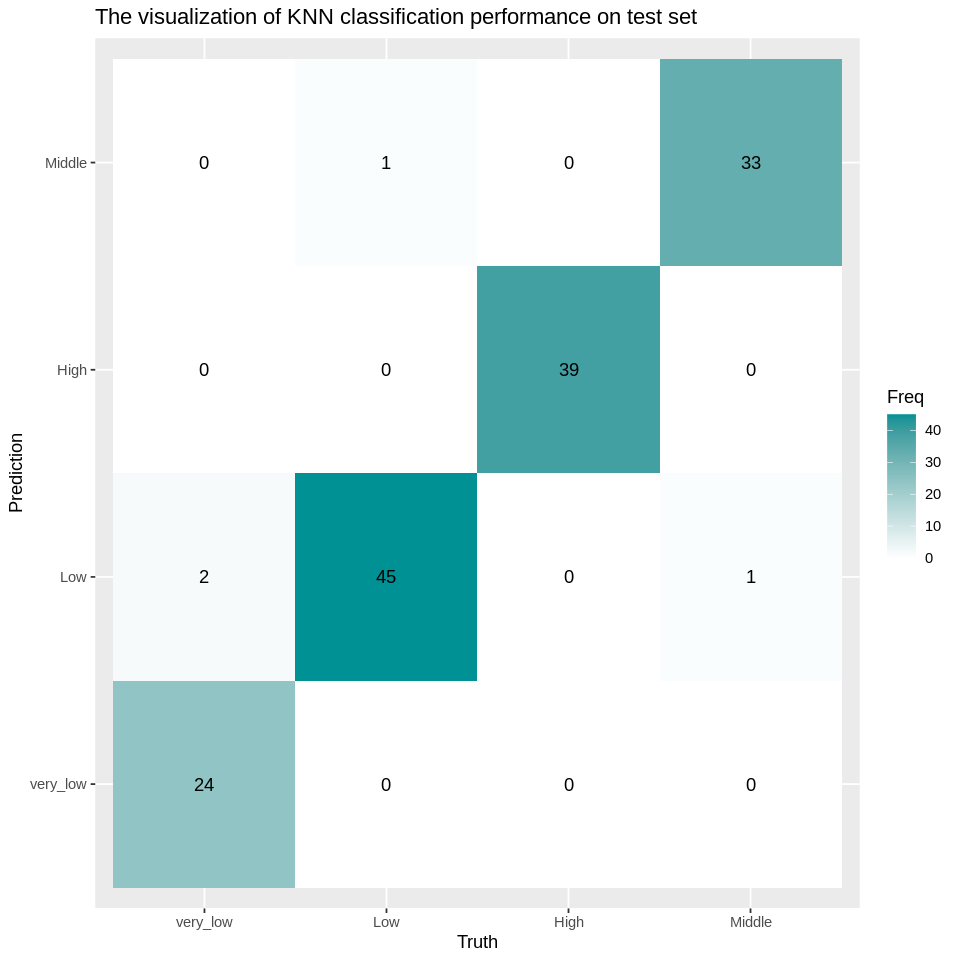

In [87]:
#Visulaize the confusion matrix
table <- data.frame( model_mat$table)
table


ggplot(plotTable, aes(x = Truth, y = Prediction, fill= Freq)) +
        geom_tile() + geom_text(aes(label=Freq)) +
        scale_fill_gradient(low="white", high="#009194") +
        labs(x = "Truth",y = "Prediction") +
        scale_x_discrete(labels=c("very_low","Low","High","Middle")) +
        scale_y_discrete(labels=c("very_low","Low","High","Middle"))+
        ggtitle("The visualization of KNN classification performance on test set")


The confusion matrix shows 24 observations were correctly predicted as very_low, and 45 were correctly predicted as Low, and 39 c, finally 33 observations were correctly predicted as Middle. Therefore the classifier labeled 24+45+39+33 = 141 observations correctly. It also shows that the classifier made some mistakes; in particular, it classified 2 observations as low when they were truly very_low, and 1 observation as low when they were truly Middle.

The reason for the prediction error might be because the data from the training data set is not balanced, and we might be able to improve the accuracy by rebalancing the data by oversampling the rare class.
As we can see from the exploratory step the "very_low" has only 24 counts, so we could use upsampling to give more voting power to the "very_low" classifier in our K-nearest neighbor algorithm